In [24]:
import os

import pandas as pd
import numpy as np
from PIL import Image

from keras.utils import to_categorical

from car_position import POS_NUM
from img_utils import process_image

img_folder = '/Volumes/CPSC587DATA/TRAINING_IMAGES'
csv_path = os.path.join(img_folder, 'info.csv')
info = pd.read_csv(csv_path)

img_list = []
for _, row in info.iterrows():
    img = Image.open(os.path.join(img_folder, row['filename']))
    img = process_image(img)
    img_list.append(np.expand_dims(img, 0))
images = np.concatenate(tuple(img_list), axis=0)
car_pos_idx = np.asarray(info['car_pos_idx'])
car_pos_one_hot = to_categorical(car_pos_idx, num_classes=POS_NUM)

In [25]:
images.shape, car_pos_one_hot.shape

((1594, 66, 200, 3), (1594, 4))

In [50]:
from keras import Input
from keras.engine import Model
from keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam

from img_utils import IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS

inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
values = inputs

conv_layer_1 = Conv2D(32, (8, 8), strides=(4, 4), padding='same', activation='relu')
values = conv_layer_1(values)
values = BatchNormalization()(values)

conv_layer_2 = Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation='relu')
values = conv_layer_2(values)
values = BatchNormalization()(values)

conv_layer_3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')
values = conv_layer_3(values)
values = BatchNormalization()(values)

max_poll_layer = MaxPooling2D(pool_size=(2, 2))
values = max_poll_layer(values)

values = Flatten()(values)
values = BatchNormalization()(values)

hidden_layer = Dense(128, activation='relu')
values = hidden_layer(values)

pos_output_layer = Dense(POS_NUM, activation='relu')
outputs = pos_output_layer(values)

model = Model(inputs=inputs, outputs=outputs)

adam = Adam(lr=0.0001)
model.compile(loss='mse', optimizer=adam)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 17, 50, 32)        6176      
_________________________________________________________________
batch_normalization_33 (Batc (None, 17, 50, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 25, 64)         32832     
_________________________________________________________________
batch_normalization_34 (Batc (None, 9, 25, 64)         256       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 9, 25, 64)         36928     
_________________________________________________________________
batch_normalization_35 (Batc (None, 9, 25, 64)         256       
__________

In [51]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, \
    accuracy_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True)

train_index, test_index = next(skf.split(images, car_pos_idx))
np.random.shuffle(train_index)

X_train = images[train_index]
y_train = car_pos_one_hot[train_index]
print(X_train.shape, y_train.shape)

model.fit(X_train, y_train, epochs=10, verbose=1)

y_pred = np.argmax(model.predict(images[test_index]), axis=1)
y_true = car_pos_idx[test_index]
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

print('{:15}'.format('Accuracy:'), accuracy_score(y_true, y_pred))
print('{:15}'.format('Precision:'), precision_score(y_true, y_pred, average=None))
print('{:15}'.format('Recall:'), recall_score(y_true, y_pred, average=None))
print('{:15}'.format('f1 score:'), f1_score(y_true, y_pred, average=None))


(1062, 66, 200, 3) (1062, 4)


Epoch 1/10


  32/1062 [..............................] - ETA: 36s - loss: 0.9652

  64/1062 [>.............................] - ETA: 19s - loss: 0.9527

  96/1062 [=>............................] - ETA: 14s - loss: 0.8725

 128/1062 [==>...........................] - ETA: 11s - loss: 0.8061

 160/1062 [===>..........................] - ETA: 9s - loss: 0.7333 

 192/1062 [====>.........................] - ETA: 8s - loss: 0.6692

 224/1062 [=====>........................] - ETA: 7s - loss: 0.6560

 256/1062 [======>.......................] - ETA: 6s - loss: 0.6336

 288/1062 [=======>......................] - ETA: 6s - loss: 0.6276

 320/1062 [========>.....................] - ETA: 5s - loss: 0.6110

 352/1062 [========>.....................] - ETA: 5s - loss: 0.5980

 384/1062 [=========>....................] - ETA: 4s - loss: 0.5824

 416/1062 [==========>...................] - ETA: 4s - loss: 0.5761

 448/1062 [===========>..................] - ETA: 4s - loss: 0.5528

 480/1062 [============>.................] - ETA: 3s - loss: 0.5359

 512/1062 [=============>................] - ETA: 3s - loss: 0.5252

 544/1062 [==============>...............] - ETA: 3s - loss: 0.5099

 576/1062 [===============>..............] - ETA: 2s - loss: 0.5050

 608/1062 [================>.............] - ETA: 2s - loss: 0.4888

 640/1062 [=================>............] - ETA: 2s - loss: 0.4779

 672/1062 [=================>............] - ETA: 2s - loss: 0.4663

 704/1062 [==================>...........] - ETA: 2s - loss: 0.4608

 736/1062 [===================>..........] - ETA: 1s - loss: 0.4513

 768/1062 [====================>.........] - ETA: 1s - loss: 0.4418

 800/1062 [=====================>........] - ETA: 1s - loss: 0.4364

 832/1062 [======================>.......] - ETA: 1s - loss: 0.4270

 864/1062 [=======================>......] - ETA: 1s - loss: 0.4201

 896/1062 [========================>.....] - ETA: 0s - loss: 0.4137

 928/1062 [=========================>....] - ETA: 0s - loss: 0.4050

 960/1062 [==========================>...] - ETA: 0s - loss: 0.4003

 992/1062 [===========================>..] - ETA: 0s - loss: 0.3949

1024/1062 [===========================>..] - ETA: 0s - loss: 0.3894

1056/1062 [============================>.] - ETA: 0s - loss: 0.3860

1062/1062 [==============================] - 5s - loss: 0.3855     


Epoch 2/10


  32/1062 [..............................] - ETA: 4s - loss: 0.1507

  64/1062 [>.............................] - ETA: 4s - loss: 0.1578

  96/1062 [=>............................] - ETA: 4s - loss: 0.1482

 128/1062 [==>...........................] - ETA: 4s - loss: 0.1501

 160/1062 [===>..........................] - ETA: 3s - loss: 0.1480

 192/1062 [====>.........................] - ETA: 3s - loss: 0.1457

 224/1062 [=====>........................] - ETA: 3s - loss: 0.1450

 256/1062 [======>.......................] - ETA: 3s - loss: 0.1428

 288/1062 [=======>......................] - ETA: 3s - loss: 0.1457

 320/1062 [========>.....................] - ETA: 3s - loss: 0.1441

 352/1062 [========>.....................] - ETA: 3s - loss: 0.1423

 384/1062 [=========>....................] - ETA: 2s - loss: 0.1438

 416/1062 [==========>...................] - ETA: 2s - loss: 0.1425

 448/1062 [===========>..................] - ETA: 2s - loss: 0.1419

 480/1062 [============>.................] - ETA: 2s - loss: 0.1411

 512/1062 [=============>................] - ETA: 2s - loss: 0.1412

 544/1062 [==============>...............] - ETA: 2s - loss: 0.1438

 576/1062 [===============>..............] - ETA: 2s - loss: 0.1433

 608/1062 [================>.............] - ETA: 1s - loss: 0.1438

 640/1062 [=================>............] - ETA: 1s - loss: 0.1448

 672/1062 [=================>............] - ETA: 1s - loss: 0.1456

 704/1062 [==================>...........] - ETA: 1s - loss: 0.1460

 736/1062 [===================>..........] - ETA: 1s - loss: 0.1459

 768/1062 [====================>.........] - ETA: 1s - loss: 0.1459

 800/1062 [=====================>........] - ETA: 1s - loss: 0.1463

 832/1062 [======================>.......] - ETA: 1s - loss: 0.1460

 864/1062 [=======================>......] - ETA: 0s - loss: 0.1452

 896/1062 [========================>.....] - ETA: 0s - loss: 0.1445

 928/1062 [=========================>....] - ETA: 0s - loss: 0.1444

 960/1062 [==========================>...] - ETA: 0s - loss: 0.1442

 992/1062 [===========================>..] - ETA: 0s - loss: 0.1445

1024/1062 [===========================>..] - ETA: 0s - loss: 0.1437

1056/1062 [============================>.] - ETA: 0s - loss: 0.1442

1062/1062 [==============================] - 4s - loss: 0.1441     


Epoch 3/10


  32/1062 [..............................] - ETA: 5s - loss: 0.1270

  64/1062 [>.............................] - ETA: 4s - loss: 0.1290

  96/1062 [=>............................] - ETA: 4s - loss: 0.1438

 128/1062 [==>...........................] - ETA: 4s - loss: 0.1402

 160/1062 [===>..........................] - ETA: 4s - loss: 0.1356

 192/1062 [====>.........................] - ETA: 3s - loss: 0.1339

 224/1062 [=====>........................] - ETA: 3s - loss: 0.1359

 256/1062 [======>.......................] - ETA: 3s - loss: 0.1347

 288/1062 [=======>......................] - ETA: 3s - loss: 0.1354

 320/1062 [========>.....................] - ETA: 3s - loss: 0.1317

 352/1062 [========>.....................] - ETA: 3s - loss: 0.1312

 384/1062 [=========>....................] - ETA: 3s - loss: 0.1283

 416/1062 [==========>...................] - ETA: 2s - loss: 0.1290

 448/1062 [===========>..................] - ETA: 2s - loss: 0.1257

 480/1062 [============>.................] - ETA: 2s - loss: 0.1267

 512/1062 [=============>................] - ETA: 2s - loss: 0.1253

 544/1062 [==============>...............] - ETA: 2s - loss: 0.1249

 576/1062 [===============>..............] - ETA: 2s - loss: 0.1254

 608/1062 [================>.............] - ETA: 2s - loss: 0.1254

 640/1062 [=================>............] - ETA: 1s - loss: 0.1290

 672/1062 [=================>............] - ETA: 1s - loss: 0.1274

 704/1062 [==================>...........] - ETA: 1s - loss: 0.1265

 736/1062 [===================>..........] - ETA: 1s - loss: 0.1267

 768/1062 [====================>.........] - ETA: 1s - loss: 0.1257

 800/1062 [=====================>........] - ETA: 1s - loss: 0.1260

 832/1062 [======================>.......] - ETA: 1s - loss: 0.1260

 864/1062 [=======================>......] - ETA: 0s - loss: 0.1259

 896/1062 [========================>.....] - ETA: 0s - loss: 0.1262

 928/1062 [=========================>....] - ETA: 0s - loss: 0.1253

 960/1062 [==========================>...] - ETA: 0s - loss: 0.1269

 992/1062 [===========================>..] - ETA: 0s - loss: 0.1269

1024/1062 [===========================>..] - ETA: 0s - loss: 0.1258

1056/1062 [============================>.] - ETA: 0s - loss: 0.1247

1062/1062 [==============================] - 4s - loss: 0.1246     


Epoch 4/10


  32/1062 [..............................] - ETA: 4s - loss: 0.0893

  64/1062 [>.............................] - ETA: 4s - loss: 0.1031

  96/1062 [=>............................] - ETA: 4s - loss: 0.1036

 128/1062 [==>...........................] - ETA: 4s - loss: 0.1137

 160/1062 [===>..........................] - ETA: 4s - loss: 0.1145

 192/1062 [====>.........................] - ETA: 3s - loss: 0.1208

 224/1062 [=====>........................] - ETA: 3s - loss: 0.1182

 256/1062 [======>.......................] - ETA: 3s - loss: 0.1204

 288/1062 [=======>......................] - ETA: 3s - loss: 0.1182

 320/1062 [========>.....................] - ETA: 3s - loss: 0.1177

 352/1062 [========>.....................] - ETA: 3s - loss: 0.1162

 384/1062 [=========>....................] - ETA: 3s - loss: 0.1168

 416/1062 [==========>...................] - ETA: 2s - loss: 0.1141

 448/1062 [===========>..................] - ETA: 2s - loss: 0.1132

 480/1062 [============>.................] - ETA: 2s - loss: 0.1136

 512/1062 [=============>................] - ETA: 2s - loss: 0.1122

 544/1062 [==============>...............] - ETA: 2s - loss: 0.1120

 576/1062 [===============>..............] - ETA: 2s - loss: 0.1112

 608/1062 [================>.............] - ETA: 2s - loss: 0.1098

 640/1062 [=================>............] - ETA: 1s - loss: 0.1093

 672/1062 [=================>............] - ETA: 1s - loss: 0.1079

 704/1062 [==================>...........] - ETA: 1s - loss: 0.1069

 736/1062 [===================>..........] - ETA: 1s - loss: 0.1063

 768/1062 [====================>.........] - ETA: 1s - loss: 0.1069

 800/1062 [=====================>........] - ETA: 1s - loss: 0.1071

 832/1062 [======================>.......] - ETA: 1s - loss: 0.1066

 864/1062 [=======================>......] - ETA: 0s - loss: 0.1060

 896/1062 [========================>.....] - ETA: 0s - loss: 0.1047

 928/1062 [=========================>....] - ETA: 0s - loss: 0.1045

 960/1062 [==========================>...] - ETA: 0s - loss: 0.1049

 992/1062 [===========================>..] - ETA: 0s - loss: 0.1044

1024/1062 [===========================>..] - ETA: 0s - loss: 0.1047

1056/1062 [============================>.] - ETA: 0s - loss: 0.1052

1062/1062 [==============================] - 4s - loss: 0.1052     


Epoch 5/10

  32/1062 [..............................] - ETA: 5s - loss: 0.1206

  64/1062 [>.............................] - ETA: 4s - loss: 0.1163

  96/1062 [=>............................] - ETA: 4s - loss: 0.1026

 128/1062 [==>...........................] - ETA: 4s - loss: 0.1001

 160/1062 [===>..........................] - ETA: 4s - loss: 0.0969

 192/1062 [====>.........................] - ETA: 4s - loss: 0.0985

 224/1062 [=====>........................] - ETA: 3s - loss: 0.0956

 256/1062 [======>.......................] - ETA: 3s - loss: 0.0939

 288/1062 [=======>......................] - ETA: 3s - loss: 0.0947

 320/1062 [========>.....................] - ETA: 3s - loss: 0.0942

 352/1062 [========>.....................] - ETA: 3s - loss: 0.0978

 384/1062 [=========>....................] - ETA: 3s - loss: 0.0988

 416/1062 [==========>...................] - ETA: 2s - loss: 0.1019

 448/1062 [===========>..................] - ETA: 2s - loss: 0.0996

 480/1062 [============>.................] - ETA: 2s - loss: 0.1002

 512/1062 [=============>................] - ETA: 2s - loss: 0.1005

 544/1062 [==============>...............] - ETA: 2s - loss: 0.0984

 576/1062 [===============>..............] - ETA: 2s - loss: 0.0994

 608/1062 [================>.............] - ETA: 2s - loss: 0.1000

 640/1062 [=================>............] - ETA: 1s - loss: 0.0984

 672/1062 [=================>............] - ETA: 1s - loss: 0.0977

 704/1062 [==================>...........] - ETA: 1s - loss: 0.0988

 736/1062 [===================>..........] - ETA: 1s - loss: 0.0974

 768/1062 [====================>.........] - ETA: 1s - loss: 0.0963

 800/1062 [=====================>........] - ETA: 1s - loss: 0.0966

 832/1062 [======================>.......] - ETA: 1s - loss: 0.0962

 864/1062 [=======================>......] - ETA: 0s - loss: 0.0956

 896/1062 [========================>.....] - ETA: 0s - loss: 0.0957

 928/1062 [=========================>....] - ETA: 0s - loss: 0.0960

 960/1062 [==========================>...] - ETA: 0s - loss: 0.0961

 992/1062 [===========================>..] - ETA: 0s - loss: 0.0972

1024/1062 [===========================>..] - ETA: 0s - loss: 0.0966

1056/1062 [============================>.] - ETA: 0s - loss: 0.0969

1062/1062 [==============================] - 4s - loss: 0.0967     


Epoch 6/10


  32/1062 [..............................] - ETA: 5s - loss: 0.0699

  64/1062 [>.............................] - ETA: 4s - loss: 0.0712

  96/1062 [=>............................] - ETA: 4s - loss: 0.0795

 128/1062 [==>...........................] - ETA: 4s - loss: 0.0888

 160/1062 [===>..........................] - ETA: 4s - loss: 0.0947

 192/1062 [====>.........................] - ETA: 4s - loss: 0.0951

 224/1062 [=====>........................] - ETA: 3s - loss: 0.0933

 256/1062 [======>.......................] - ETA: 3s - loss: 0.0949

 288/1062 [=======>......................] - ETA: 3s - loss: 0.0942

 320/1062 [========>.....................] - ETA: 3s - loss: 0.0930

 352/1062 [========>.....................] - ETA: 3s - loss: 0.0925

 384/1062 [=========>....................] - ETA: 3s - loss: 0.0911

 416/1062 [==========>...................] - ETA: 3s - loss: 0.0913

 448/1062 [===========>..................] - ETA: 2s - loss: 0.0931

 480/1062 [============>.................] - ETA: 2s - loss: 0.0923

 512/1062 [=============>................] - ETA: 2s - loss: 0.0904

 544/1062 [==============>...............] - ETA: 2s - loss: 0.0898

 576/1062 [===============>..............] - ETA: 2s - loss: 0.0899

 608/1062 [================>.............] - ETA: 2s - loss: 0.0900

 640/1062 [=================>............] - ETA: 1s - loss: 0.0897

 672/1062 [=================>............] - ETA: 1s - loss: 0.0946

 704/1062 [==================>...........] - ETA: 1s - loss: 0.0945

 736/1062 [===================>..........] - ETA: 1s - loss: 0.0949

 768/1062 [====================>.........] - ETA: 1s - loss: 0.0948

 800/1062 [=====================>........] - ETA: 1s - loss: 0.0953

 832/1062 [======================>.......] - ETA: 1s - loss: 0.0945

 864/1062 [=======================>......] - ETA: 0s - loss: 0.0937

 896/1062 [========================>.....] - ETA: 0s - loss: 0.0940

 928/1062 [=========================>....] - ETA: 0s - loss: 0.0943

 960/1062 [==========================>...] - ETA: 0s - loss: 0.0951

 992/1062 [===========================>..] - ETA: 0s - loss: 0.0952

1024/1062 [===========================>..] - ETA: 0s - loss: 0.0948

1056/1062 [============================>.] - ETA: 0s - loss: 0.0956

1062/1062 [==============================] - 4s - loss: 0.0966     


Epoch 7/10


  32/1062 [..............................] - ETA: 5s - loss: 0.0870

  64/1062 [>.............................] - ETA: 4s - loss: 0.0827

  96/1062 [=>............................] - ETA: 4s - loss: 0.0849

 128/1062 [==>...........................] - ETA: 4s - loss: 0.0932

 160/1062 [===>..........................] - ETA: 4s - loss: 0.0982

 192/1062 [====>.........................] - ETA: 4s - loss: 0.1023

 224/1062 [=====>........................] - ETA: 3s - loss: 0.1021

 256/1062 [======>.......................] - ETA: 3s - loss: 0.1039

 288/1062 [=======>......................] - ETA: 3s - loss: 0.1029

 320/1062 [========>.....................] - ETA: 3s - loss: 0.1031

 352/1062 [========>.....................] - ETA: 3s - loss: 0.1050

 384/1062 [=========>....................] - ETA: 3s - loss: 0.1046

 416/1062 [==========>...................] - ETA: 3s - loss: 0.1079

 448/1062 [===========>..................] - ETA: 2s - loss: 0.1089

 480/1062 [============>.................] - ETA: 2s - loss: 0.1105

 512/1062 [=============>................] - ETA: 2s - loss: 0.1098

 544/1062 [==============>...............] - ETA: 2s - loss: 0.1088

 576/1062 [===============>..............] - ETA: 2s - loss: 0.1089

 608/1062 [================>.............] - ETA: 2s - loss: 0.1092

 640/1062 [=================>............] - ETA: 1s - loss: 0.1085

 672/1062 [=================>............] - ETA: 1s - loss: 0.1087

 704/1062 [==================>...........] - ETA: 1s - loss: 0.1080

 736/1062 [===================>..........] - ETA: 1s - loss: 0.1059

 768/1062 [====================>.........] - ETA: 1s - loss: 0.1056

 800/1062 [=====================>........] - ETA: 1s - loss: 0.1074

 832/1062 [======================>.......] - ETA: 1s - loss: 0.1079

 864/1062 [=======================>......] - ETA: 0s - loss: 0.1065

 896/1062 [========================>.....] - ETA: 0s - loss: 0.1069

 928/1062 [=========================>....] - ETA: 0s - loss: 0.1065

 960/1062 [==========================>...] - ETA: 0s - loss: 0.1063

 992/1062 [===========================>..] - ETA: 0s - loss: 0.1068

1024/1062 [===========================>..] - ETA: 0s - loss: 0.1065

1056/1062 [============================>.] - ETA: 0s - loss: 0.1071

1062/1062 [==============================] - 4s - loss: 0.1070     


Epoch 8/10
  32/1062 [..............................] - ETA: 4s - loss: 0.0994

  64/1062 [>.............................] - ETA: 4s - loss: 0.1079

  96/1062 [=>............................] - ETA: 4s - loss: 0.1007

 128/1062 [==>...........................] - ETA: 4s - loss: 0.0981

 160/1062 [===>..........................] - ETA: 4s - loss: 0.0935

 192/1062 [====>.........................] - ETA: 4s - loss: 0.0941

 224/1062 [=====>........................] - ETA: 3s - loss: 0.0929

 256/1062 [======>.......................] - ETA: 3s - loss: 0.0907

 288/1062 [=======>......................] - ETA: 3s - loss: 0.0915

 320/1062 [========>.....................] - ETA: 3s - loss: 0.0913

 352/1062 [========>.....................] - ETA: 3s - loss: 0.0902

 384/1062 [=========>....................] - ETA: 3s - loss: 0.0913

 416/1062 [==========>...................] - ETA: 3s - loss: 0.0906

 448/1062 [===========>..................] - ETA: 2s - loss: 0.0913

 480/1062 [============>.................] - ETA: 2s - loss: 0.0906

 512/1062 [=============>................] - ETA: 2s - loss: 0.0910

 544/1062 [==============>...............] - ETA: 2s - loss: 0.0922

 576/1062 [===============>..............] - ETA: 2s - loss: 0.0918

 608/1062 [================>.............] - ETA: 2s - loss: 0.0915

 640/1062 [=================>............] - ETA: 1s - loss: 0.0915

 672/1062 [=================>............] - ETA: 1s - loss: 0.0919

 704/1062 [==================>...........] - ETA: 1s - loss: 0.0925

 736/1062 [===================>..........] - ETA: 1s - loss: 0.0924

 768/1062 [====================>.........] - ETA: 1s - loss: 0.0941

 800/1062 [=====================>........] - ETA: 1s - loss: 0.0929

 832/1062 [======================>.......] - ETA: 1s - loss: 0.0934

 864/1062 [=======================>......] - ETA: 0s - loss: 0.0937

 896/1062 [========================>.....] - ETA: 0s - loss: 0.0938

 928/1062 [=========================>....] - ETA: 0s - loss: 0.0952

 960/1062 [==========================>...] - ETA: 0s - loss: 0.0954

 992/1062 [===========================>..] - ETA: 0s - loss: 0.0949

1024/1062 [===========================>..] - ETA: 0s - loss: 0.0949

1056/1062 [============================>.] - ETA: 0s - loss: 0.0947

1062/1062 [==============================] - 4s - loss: 0.0948     

Epoch 9/10


  32/1062 [..............................] - ETA: 5s - loss: 0.1025

  64/1062 [>.............................] - ETA: 5s - loss: 0.0946

  96/1062 [=>............................] - ETA: 4s - loss: 0.0968

 128/1062 [==>...........................] - ETA: 4s - loss: 0.0982

 160/1062 [===>..........................] - ETA: 4s - loss: 0.1053

 192/1062 [====>.........................] - ETA: 4s - loss: 0.1157

 224/1062 [=====>........................] - ETA: 4s - loss: 0.1124

 256/1062 [======>.......................] - ETA: 3s - loss: 0.1084

 288/1062 [=======>......................] - ETA: 3s - loss: 0.1095

 320/1062 [========>.....................] - ETA: 3s - loss: 0.1077

 352/1062 [========>.....................] - ETA: 3s - loss: 0.1052

 384/1062 [=========>....................] - ETA: 3s - loss: 0.1063

 416/1062 [==========>...................] - ETA: 3s - loss: 0.1058

 448/1062 [===========>..................] - ETA: 2s - loss: 0.1046

 480/1062 [============>.................] - ETA: 2s - loss: 0.1035

 512/1062 [=============>................] - ETA: 2s - loss: 0.1043

 544/1062 [==============>...............] - ETA: 2s - loss: 0.1037

 576/1062 [===============>..............] - ETA: 2s - loss: 0.1030

 608/1062 [================>.............] - ETA: 2s - loss: 0.1016

 640/1062 [=================>............] - ETA: 1s - loss: 0.1014

 672/1062 [=================>............] - ETA: 1s - loss: 0.1013

 704/1062 [==================>...........] - ETA: 1s - loss: 0.1010

 736/1062 [===================>..........] - ETA: 1s - loss: 0.1008

 768/1062 [====================>.........] - ETA: 1s - loss: 0.0998

 800/1062 [=====================>........] - ETA: 1s - loss: 0.0997

 832/1062 [======================>.......] - ETA: 1s - loss: 0.1017

 864/1062 [=======================>......] - ETA: 0s - loss: 0.1012

 896/1062 [========================>.....] - ETA: 0s - loss: 0.1005

 928/1062 [=========================>....] - ETA: 0s - loss: 0.1010

 960/1062 [==========================>...] - ETA: 0s - loss: 0.1012

 992/1062 [===========================>..] - ETA: 0s - loss: 0.1007

1024/1062 [===========================>..] - ETA: 0s - loss: 0.1020

1056/1062 [============================>.] - ETA: 0s - loss: 0.1027

1062/1062 [==============================] - 4s - loss: 0.1031     


Epoch 10/10


  32/1062 [..............................] - ETA: 5s - loss: 0.1010

  64/1062 [>.............................] - ETA: 4s - loss: 0.0901

  96/1062 [=>............................] - ETA: 4s - loss: 0.0841

 128/1062 [==>...........................] - ETA: 4s - loss: 0.0855

 160/1062 [===>..........................] - ETA: 4s - loss: 0.0842

 192/1062 [====>.........................] - ETA: 4s - loss: 0.0865

 224/1062 [=====>........................] - ETA: 4s - loss: 0.0872

 256/1062 [======>.......................] - ETA: 3s - loss: 0.0894

 288/1062 [=======>......................] - ETA: 3s - loss: 0.0886

 320/1062 [========>.....................] - ETA: 3s - loss: 0.0870

 352/1062 [========>.....................] - ETA: 3s - loss: 0.0859

 384/1062 [=========>....................] - ETA: 3s - loss: 0.0843

 416/1062 [==========>...................] - ETA: 3s - loss: 0.0857

 448/1062 [===========>..................] - ETA: 2s - loss: 0.0853

 480/1062 [============>.................] - ETA: 2s - loss: 0.0879

 512/1062 [=============>................] - ETA: 2s - loss: 0.0870

 544/1062 [==============>...............] - ETA: 2s - loss: 0.0856

 576/1062 [===============>..............] - ETA: 2s - loss: 0.0859

 608/1062 [================>.............] - ETA: 2s - loss: 0.0865

 640/1062 [=================>............] - ETA: 1s - loss: 0.0882

 672/1062 [=================>............] - ETA: 1s - loss: 0.0882

 704/1062 [==================>...........] - ETA: 1s - loss: 0.0897

 736/1062 [===================>..........] - ETA: 1s - loss: 0.0897

 768/1062 [====================>.........] - ETA: 1s - loss: 0.0897

 800/1062 [=====================>........] - ETA: 1s - loss: 0.0889

 832/1062 [======================>.......] - ETA: 1s - loss: 0.0894

 864/1062 [=======================>......] - ETA: 0s - loss: 0.0898

 896/1062 [========================>.....] - ETA: 0s - loss: 0.0892

 928/1062 [=========================>....] - ETA: 0s - loss: 0.0889

 960/1062 [==========================>...] - ETA: 0s - loss: 0.0896

 992/1062 [===========================>..] - ETA: 0s - loss: 0.0898

1024/1062 [===========================>..] - ETA: 0s - loss: 0.0897

1056/1062 [============================>.] - ETA: 0s - loss: 0.0901

1062/1062 [==============================] - 4s - loss: 0.0904     

Confusion Matrix:
[[283   2   3   3]
 [ 16  31   0   1]
 [ 26   2  53   2]
 [ 61   4   3  42]]
Accuracy:       0.768796992481
Precision:      [ 0.73316062  0.79487179  0.89830508  0.875     ]
Recall:         [ 0.97250859  0.64583333  0.63855422  0.38181818]
f1 score:       [ 0.83604136  0.71264368  0.74647887  0.53164557]


(66, 200, 3)


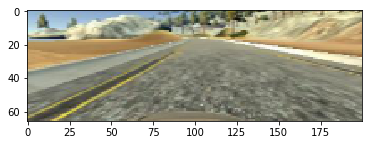

In [52]:
import random
import matplotlib.pyplot as plt

plt.close('all')
img = images[random.randrange(images.shape[0])]
print(img.shape)
fig = plt.figure()
plt.imshow(img)
fig

In [53]:
from keras import backend as K


def visualize_conv(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])

    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(np.expand_dims(img, 0))
    convolutions = np.squeeze(convolutions)

    print('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12, 8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n, n, i + 1)
        ax.imshow(convolutions[:, :, i], cmap='gray')
    return fig

Shape of conv: (17, 50, 32)


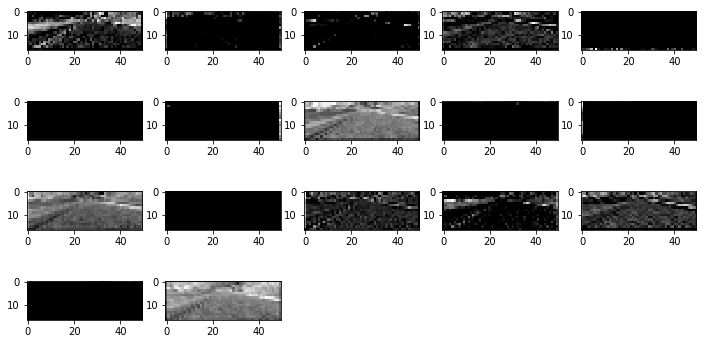

In [54]:
plt.close('all')
visualize_conv(conv_layer_1)

Shape of conv: (9, 25, 64)


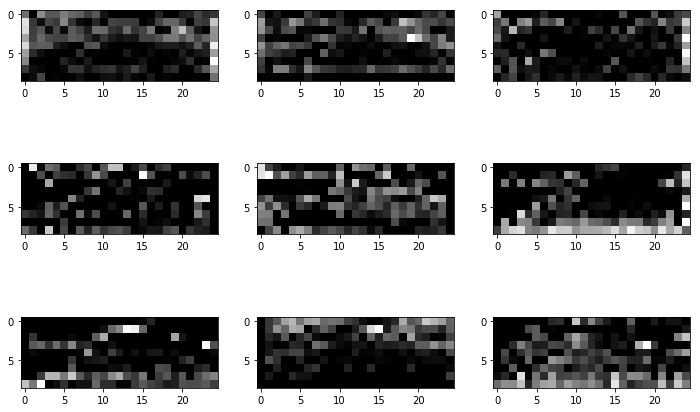

In [55]:
plt.close('all')
visualize_conv(conv_layer_2)

Shape of conv: (9, 25, 64)


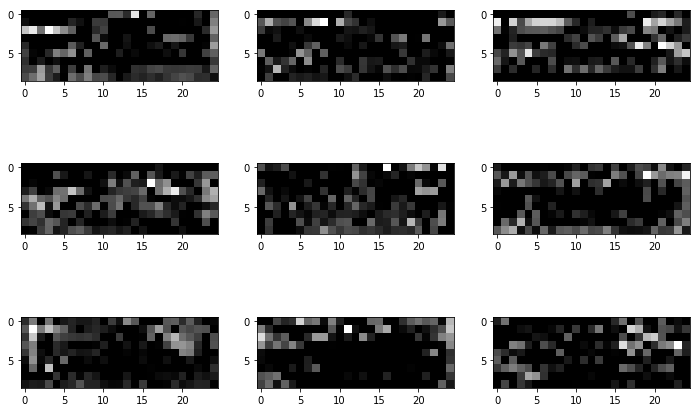

In [56]:
plt.close('all')
visualize_conv(conv_layer_3)

Shape of conv: (4, 12, 64)


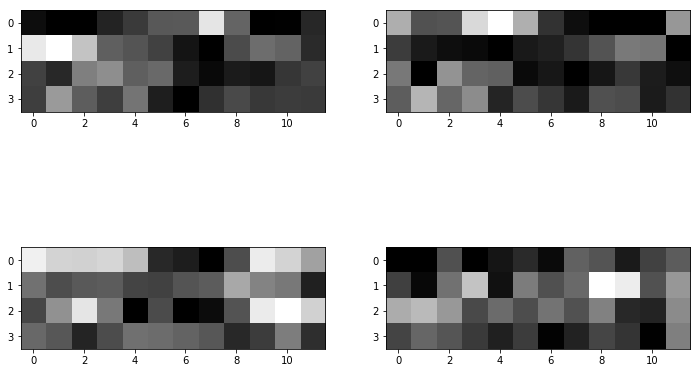

In [57]:
plt.close('all')
visualize_conv(max_poll_layer)